<a id='top'></a>
# <font color='blue'> ANN - Canada Real Estate </font>

Links to section:

+ [Preprocessing](#preproc)

+ [MLP Neural Networks](#neural)

+ [GridSearch C.V.](#grid_search)

+ [Notes](#notes)

+ [Keras](#keras)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import re


cols = ['price', 'sqft', 'bed', 'bath', 'property type', 'year built', 'stories', 'city', 'postal code']

df = pd.read_csv('real_estate_listing.csv', usecols=cols)

# Integrating Connor's preprocessing
prop_types = {
    'Single Family': 0,
    'Multi-Family': 1,
    'Condo': 2,
    'Townhome': 3,
    'Duplex': 4,
    'Manufactured Home': 5,
    'Mobile Home': 6,
    'Farm': 7
}
# Encode `property type`
df['property type'] = df['property type'].map(prop_types)

# format `prices` into integers 
df['price'] = df['price'].str.replace(',','').str.replace('$','').str.replace('"','')
df['price'] = df['price'].str.replace("[",'').str.replace("]",'').str.replace("'",'')
df['price'] = df['price'].astype(int)
# remove all property price less than $10,000 
# some entries might be for-rent instead of for-sale or trailer park
indexes = df[ df['price'] <= 10000 ].index
df.drop(indexes, inplace=True)
# encode `prices`
for i in range(21):
    df['price'] = df['price'].mask(df['price'] > ((20-i)*100000)+25, 20-i)

# format `sqft` (of living area) column
df['sqft'] = df['sqft'].str.replace('sqft', '').str.replace('SQFT', '').str.replace(' ', '')
df['sqft'] = df['sqft'].replace('[0-9].*-', '', regex=True)
df['sqft'] = df['sqft'].replace('m.*', '', regex=True)
df['sqft'] = df['sqft'].str.replace('+', '')

# format `stories` column 
df['stories'] = df['stories'].replace('[^0-9].*','', regex=True)
df['stories'] = df['stories'].str.replace('[.].*','', regex=True)
df['stories'] = df['stories'].replace('', np.nan)
df['stories'] = df['stories'].astype(float)
indexes = df[ df['stories'] > 5 ].index
df.drop(indexes , inplace=True)

# remove much older properties
indexes = df[ df['year built'] <= 1600 ].index
df.drop(indexes , inplace=True)
    

# Could affect farm if removing bath = 0 and bed = 0
# indexes = df2[ df2['bath'] < 1 ].index
# df2.drop(indexes , inplace=True)

# indexes = df2[ df2['bed'] < 1 ].index
# df2.drop(indexes , inplace=True)

# ---------------------------------------------------------------
# Selecting the number of labels (classes) to predict by grouping
# without grouping, there are classes from 0 to 20
# grouping:
df['price'].replace([0,1], 1, inplace=True)
df['price'].replace([2,3], 2, inplace=True)
df['price'].replace([4,5,6,7], 3, inplace=True)
df['price'].replace([range(8,21)], 4, inplace=True)


sizes = df.groupby('price').size()
print(sizes)


/home/matt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


price
1     8573
2    11067
3    10965
4     6547
dtype: int64


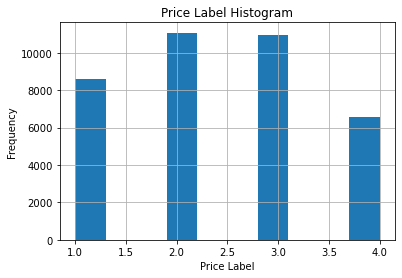

In [2]:
plt.xlabel('Price Label')
plt.ylabel('Frequency')
plt.title('Price Label Histogram')
df['price'].hist()
# ylabel='Frequency', title='Price Class Histogram'


## Encode Features

[ 8  7  9 10 11  1 15  2 12 16 14  0  3 13]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd75744c90>,
      dtype=object)

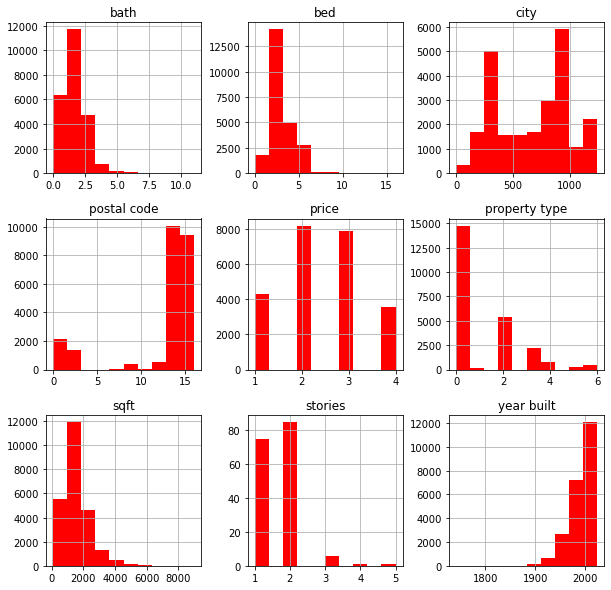

In [12]:
# Integrating Naomi's preprocessing
# 1. convert the `postal code` column into `capital`
# 2. encode `city` column (list of strings) into integers

#https://www.citypopulation.de/en/canada/cities/
# capitals = [
#     'Edmonton', # Alberta
#     'Victoria', # BC
#     'Ottawa', # Canada
#     'Whitehorse', # Yukon
#     'Regina', # Saskatchewan
#     'Quebec', # Montréal
#     'Charlottetown', # Prince Edward Island
#     'Toronto', # Ontario
#     'Iqalit', # Nunavut 
#     'Halifax', # Nova Scotia
#     'Yellowknife', # Northwest Territories 
#     "St. John's", # Newfoundland and Labrador
#     'Fredericton', # New Brunswick
#     'Winnipeg' # Manitoba
# ]

#---------------- encode city column ----------------------
indexNames = df[ df['city'] == np.nan ].index
df.drop(indexNames , inplace=True)

df['city'] = df['city'].str.lower()
len(df['city'].unique())
j=df['city'].unique()
je=df['city'].unique()
for x in range(len(df['city'].unique())):
    j[x]=x
j
r=dict(zip(je,j ))
df.replace({"city": r}, inplace=True)
#----------------------------------------------------------


#https://www150.statcan.gc.ca/n1/pub/92-195-x/2011001/other-autre/pc-cp/tbl/tbl9-eng.htm

provinces = {
    'A': 0, #'Newfoundland and Labrador',
    'B': 1, #'Nova Scotia',
    'C': 2, #'Prince Edward Island',
    'E': 3, #'New Brunswick',
    'G': 4, #'Eastern Quebec',
    'H': 5, #'Metropolitan Montréal',
    'J': 6, #'Western Quebec',
    'K': 7, #'Eastern Ontario',
    'L': 8, #'Central Ontario',
    'M': 9, #'Metropolitan Toronto',
    'N': 10, #'Southwestern Ontario',
    'P': 11, #'Northern Ontario',
    'R': 12, #'Manitoba',
    'S': 13, #'Saskatchewan',
    'T': 14, #'Alberta',
    'V': 15, #'British Columbia',
    'X': 16, #'Northwest Territories and Nunavut',
    'Y': 17 #'Yukon'
}


for p in provinces:
    df.loc[df['postal code'].str.startswith(p, na=False), 'postal code'] = provinces[p]
    
df['postal code'].unique()


# remove the failed-to-encode rows
df.drop(df[ 
    (df['postal code'] == 'Innisfil') | 
    (df['postal code'] == 'ON, ') # This drops 1442 entries
].index, inplace=True)

indexes = df[ df['postal code'] == 'Fairmont/Columbia Lake, '].index
df.drop(indexes , inplace=True)
indexes = df[ df['postal code'] == 'Qualicum Beach, '].index
df.drop(indexes , inplace=True)
indexes = df[ df['postal code'] == 'Whitecourt Rural, '].index
df.drop(indexes , inplace=True)
indexes = df[ df['postal code'] == 'O0O 0O0'].index
df.drop(indexes , inplace=True)
df['postal code'] = df['postal code'].astype(int)

print(df['postal code'].unique())
df.hist(figsize=(10,10), color='r')

In [14]:
df.describe()

,bath,bed,city,postal code,price,property type,sqft,stories,year built
count,23891.000000,23930.000000,24024.000000,24024.000000,24024.000000,23989.000000,24024.000000,168.000000,22808.000000
mean,2.040768,3.109319,672.368506,12.239469,2.447552,1.026846,1577.202560,1.619048,1991.853648
std,0.886017,1.286883,321.511943,4.768597,0.950901,1.465186,816.014037,0.645663,25.054543
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,102.000000,1.000000,1741.000000
25%,1.000000,2.000000,320.000000,13.000000,2.000000,0.000000,1014.000000,1.000000,1977.000000
50%,2.000000,3.000000,757.000000,14.000000,2.000000,0.000000,1349.000000,2.000000,1998.000000
75%,2.000000,4.000000,925.000000,15.000000,3.000000,2.000000,1968.962500,2.000000,2012.000000
max,11.000000,16.000000,1240.000000,16.000000,4.000000,6.000000,9000.000000,5.000000,2024.000000


<a id='preproc'></a>
## Data Preprocessing

[top of page](#top)


In [15]:
df.columns

Index(['bath', 'bed', 'city', 'postal code', 'price', 'property type', 'sqft',
       'stories', 'year built'],
      dtype='object')

In [16]:
print(df.shape)

df.drop(df[ 
    (df['year built'] == 553) | 
    (df['year built'] == 1021)
].index, inplace=True)

print(df.shape)

(24024, 9)
(24024, 9)


In [17]:
df.dropna(subset = ['sqft'], inplace=True)
df['sqft'] = df['sqft'].astype(float)

df.drop(df[
(df['sqft'] > 10000) |
(df['sqft'] <= 100)
].index, inplace=True)

X=df.drop(['price'], axis=1)
y=df['price']

# for printing histograms
X_dist = X
y_dist = y


# Fill a NaN cell with the mean value of its column
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)
X = X.astype(int)


X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=0)


# Feature Selection with Feature Correlation
# https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
# remove features that have correlation >= 0.5
# corr = X_train.corr()
# sn.heatmap(corr)
# columns = np.full((corr.shape[0],), True, dtype=bool)
# for i in range(corr.shape[0]):
#     for j in range(i+1, corr.shape[0]):
#         if corr.iloc[i,j] >= 0.5:
#             if columns[j]:
#                 columns[j] = False
                
# selected_columns = X_train.columns[columns-1]
# X_train = X_train[selected_columns]
# X_test = X_test[selected_columns]
# print(X_train.columns)

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Normalizing
# from sklearn.preprocessing import Normalizer
# norm = Normalizer()
# norm.fit(X_train)
# X_train = norm.transform(X_train)
# X_test = norm.transform(X_test)



### Feature Selection (1)
+ is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for several reasons:

    + simplification of models to make them easier to interpret,
    + shorter training times,
    + to avoid the <u><b>curse of dimensionality</u></b>(2),
        + when the dimension of the feature space (feature vector) increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance. In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality.
        + there should be at least 5 training examples for each dimension
    + enhanced generalization by reducing overfitting (formally, reduction of variance)
    
<font color='red'>Feature selection doesn't seem to improve accuracy at all, unlike reducing number of label that leads to more examples for each label to predict.</font>

#### Correlation (3):

Type | Correlation Score | Description
:---: | :---: | :---:
Perfect | near ± 1 | as one variable increases, the other variable tends to also increase (if positive) or decrease (if negative).
High degree | [± 0.50, ± 1) | it is said to be a strong correlation.
Moderate degree | [ ± 0.30, ± 0.49] | it is said to be a medium correlation.
Low degree | below + .29 | small correlation.
No correlation | 0


(1) https://en.wikipedia.org/wiki/Feature_selection

(2) https://en.wikipedia.org/wiki/Curse_of_dimensionality

(3) https://www.statisticssolutions.com/pearsons-correlation-coefficient/

<a id='neural'></a>
# Neural Network
[top of page](#top)

In [26]:
mlp=MLPClassifier(activation='relu',solver='adam', alpha = 0.0001,
                  max_iter=5000,learning_rate='constant', batch_size=256,
                  hidden_layer_sizes=(100),
                  random_state=0)

mlp.fit(X_train,y_train)
mlp_prediction=mlp.predict(X_test)
print(mlp.score(X_test,y_test))
cf=confusion_matrix(y_test,mlp_prediction)


plt.imshow(cf,cmap='binary', interpolation='None')
plt.show()
pd.crosstab(y_test, mlp_prediction, rownames=['True'],colnames=['Predicted'], margins=True)

# Optimal
# {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 256, 'learning_rate': 'constant', 'solver': 'adam'}
# ['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_activation', 'param_alpha', 'param_batch_size', 'param_learning_rate', 'param_solver', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']



0.6783187682064087


In [27]:
mlp.score(X_train, y_train), mlp.score(X_test, y_test)


(0.7031127144905416, 0.6783187682064087)

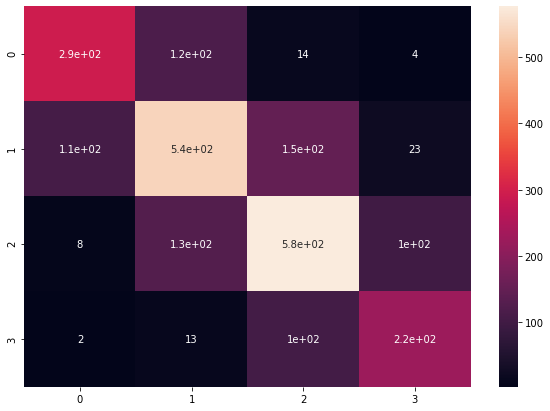

In [24]:
ann_cm = pd.DataFrame(cf, index = [i for i in range(0, max(y_train))],
                  columns = [i for i in range(0, max(y_train))])

plt.figure(figsize = (10,7))
sn.heatmap(ann_cm, annot=True)


In [14]:
pd.crosstab(y_test, mlp_prediction, rownames=['True'],colnames=['Predicted'], margins=True)

Predicted,1,2,3,4,All
True,,,,,
1,293,117,14,4,428
2,106,542,148,23,819
3,8,127,577,100,812
4,2,13,104,225,344
All,409,799,843,352,2403


# GridSearchCV (slow)

In [22]:
# from sklearn.model_selection import GridSearchCV

# # more grid search parameters -> extremely slow!!!!
# # parameters = {
# #     'alpha':[0.0031, 0.031], 
# #     'activation':('logistic', 'relu'),
# #     'learning_rate':('constant','adaptive'),
# #     'solver':('sgd','adam')
# # }

# parameters = {
#     'alpha':[0.0001, 0.001, 0.01, 0.1], 
#     'activation':('logistic', 'relu'),
#     'learning_rate':('constant','adaptive', 'invscaling'),
#     'solver':('lbfg','sgd','adam'),
#     'batch_size':[64,128,256]
# }


# mlp=MLPClassifier(max_iter=2000, batch_size=200,hidden_layer_sizes=100,random_state=0)
                    
# grid_search = GridSearchCV(estimator = mlp, param_grid = parameters, scoring = 'accuracy',
#                            cv = 5,verbose=10, n_jobs=4)
# grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 12.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 15.9min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 17.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 19.7min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 22.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 25.2min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 28.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 31.8min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 34.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 40.7min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 46.3min
[Parallel(

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size=200, beta_1=0.9, beta_2=0.999,
                                     early_stopping=False, epsilon=1e-08,
                                     hidden_layer_sizes=100,
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=2000, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=0, sh...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'activation': ('logistic', 'relu'),
                         'alpha': [0.0001, 0.0

In [23]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print(best_accuracy)
print(best_parameters)
print(sorted(grid_search.cv_results_.keys()))

0.6882197066514092
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 256, 'learning_rate': 'constant', 'solver': 'adam'}
['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_activation', 'param_alpha', 'param_batch_size', 'param_learning_rate', 'param_solver', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']


array([0.00000000e+00, 8.82630273e-04, 6.94193121e-04, 0.00000000e+00,
       1.39697777e-04, 1.63423538e-04, 0.00000000e+00, 1.96614341e-04,
       5.35907170e-04, 0.00000000e+00, 2.48454289e-04, 4.72818930e-04,
       0.00000000e+00, 1.67851380e-04, 3.85188130e-04, 0.00000000e+00,
       2.07737182e-04, 2.74805577e-04, 0.00000000e+00, 2.99804779e-04,
       1.10510827e-03, 0.00000000e+00, 1.25761640e-04, 6.72612227e-04,
       0.00000000e+00, 4.74927272e-04, 5.58573580e-04, 0.00000000e+00,
       9.94866081e-05, 2.05344407e-04, 0.00000000e+00, 4.42403656e-04,
       2.85074454e-04, 0.00000000e+00, 2.82669429e-04, 4.52649200e-04,
       0.00000000e+00, 3.80530303e-04, 9.26876530e-03, 0.00000000e+00,
       1.71192934e-04, 2.82159378e-04, 0.00000000e+00, 5.47645444e-04,
       4.50237755e-04, 0.00000000e+00, 5.32333059e-04, 6.03675115e-04,
       0.00000000e+00, 4.02073197e-04, 7.59941366e-03, 0.00000000e+00,
       2.96016322e-04, 6.75446582e-04, 0.00000000e+00, 1.67774895e-04,
      

<a id='notes'></a>
# <u>Notes</u>


[top of page](#top)


#### Model not learning
http://theorangeduck.com/page/neural-network-not-working#normalize

### Multi-Class Neural Networks (1)

Pick from multiple possibilities: Is this an image of an apple, bear, candy, dog, or egg?
 
<b> One vs. All </b>
+ provides a way to leverage binary classification. Given a classification problem with N possible solutions, a one-vs.-all solution consists of N separate binary classifiers—one binary classifier for each possible outcome.
    1. Is this image an apple? No.
    + Is this image a bear? No.
    + Is this image candy? No.
    + Is this image a dog? Yes.
    + Is this image an egg? No.
    
+ This approach is fairly reasonable when the total number of classes is small, but becomes increasingly inefficient as the number of classes rises.


### Activation Functions 

+ SoftMax (1)
    + LogReg produces an output in the range [0,1.0] (binary classification), softmax extends this idea by assigning probability to each class (for n classes, $\sum_{i=0}^n P_i = 1.0$).
    + Softmax assumes that each example is a member of <u>exactly one class</u>.
        + Use LogReg instead if examples are member of multiple classes.
    + Advantanges (2)
        + Able to handle multiple classes only one class in other activation functions—normalizes the outputs for each class between 0 and 1, and divides by their sum, giving the probability of the input value being in a specific class.
        + Useful for output neurons—typically Softmax is used only for the output layer, for neural networks that need to classify inputs into multiple categories.

   
   
(1) https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all

(2) https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/


<a id='keras'></a>
## Keras ANN
[top of page](#top)

+ A more scalable and advanced NN model 
+ Can manually tweak each layer
+ Sometimes need to restart the kernel to clear saved variables/models

+ Dropout = regularization technique for reducing overfitting.
    + The term "dropout" refers to dropping out units (both hidden and visible) in a neural network
   

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

X_train = np.array(X_train)
y_train = np.array(y_train)

# #https://keras.io/models/sequential/

from tensorflow.keras import optimizers
model = Sequential()
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.8, nesterov=True)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


# try: epochs 200
model.fit(X_train, y_train, epochs=100, batch_size=300)

# 0.7653 adam

# 10% split 0.7387 train, 0.6950 test

# 28,564 examples.. what is a good batch size?

In [ ]:
y_pred = model.predict(X_train)

model.evaluate(X_test, y_test.values, verbose=0)

In [ ]:
# model.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=5)
from sklearn import metrics

y_pred_float = model.predict(X_test)
y_pred = []
for i in y_pred_float:
    y_pred.append(int(np.argmax(i)))

# y_pred
# print("Acc. score: ", metrics.accuracy_score(y_test, y_pred))

cf=confusion_matrix(y_test.values, y_pred)
ann_cm = pd.DataFrame(cf, index = [i for i in range(0, max(y_train))],
                  columns = [i for i in range(0, max(y_train))])

plt.figure(figsize = (10,7))
sn.heatmap(ann_cm, annot=True)


In [ ]:
# print("Class Predictions: ")
# classes = [i for i in range(0, max(y_train))]
# for i in classes:
#     print(i,"\t ", end="")
# print("\n")
    
# for index, i in enumerate(classifier.predict(X_test)):
#     for j in i:
#         print('%.3f\t' % j, end="")
#     print("\tpredicted: ", np.argwhere(i==max(i))[0][0]," actual: ", y_test.iloc[index], "\n")

# model.evaluate(X_test, y_test.values, verbose=0, use_multiprocessing=True)
df = pd.DataFrame({'True':y_test.values, 'Predicted':y_pred})
# df = df.reindex(index=y_test.values, columns=y_pred, fill_value=0)
pd.crosstab(df['True'], df['Predicted'], margins=True)

### Helper Functions

In [ ]:
from matplotlib import pyplot as plt

# Calculate train vs test error of a classifier.
def calculate_errors(classifier, parameter, param_range, X_train, y_train, X_test, y_test):
    train_errors = list()
    test_errors = list()
    for i in param_range:
        eval('classifier.set_params(' + parameter + '=i)')
        classifier.fit(X_train, y_train)
        train_errors.append(classifier.score(X_train, y_train))
        test_errors.append(classifier.score(X_test, y_test))
    return (train_errors, test_errors)

def graph_train_test_errors(train_errors, test_errors, param, param_range, title):
    lw = 2
    plt.plot(param_range, train_errors, label="Train",color="darkorange", lw=lw)
    plt.plot(param_range, test_errors, label="Test",  color="navy", lw=lw)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Number of ' + param.upper())
    plt.ylabel('Accuracy')
    plt.autoscale()
    plt.show()
    
# shuffle two lists with same order
# Author: Francesco Montesano 
# source: https://stackoverflow.com/questions/23289547/shuffle-two-list-at-once-with-same-order
def shuffle_in_unison(a, b):
    n_elem = a.shape[0]
    indices = np.random.choice(n_elem, size=n_elem, replace=False)
    return a[indices], b[indices]